In [2]:
%load_ext autoreload
%autoreload 2

In [20]:
#export
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
from glob import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns; sns.set(color_codes=True)
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import manifold,neighbors
from sklearn.model_selection import train_test_split
from scipy.cluster.hierarchy import dendrogram, linkage, to_tree, fcluster,distance  
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from Bio import SeqIO
from Bio.Align import MultipleSeqAlignment
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor
from Bio import Phylo
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
import gc
import random
import multiprocessing as mp

### Sample Ksent 

In [ ]:
#export
FASTA = "/home/serge/development/genomes/ncbi-genomes-2019-04-07/bacterial genomes/"
labels = []
ff = glob(f"{FASTA}*.fna")

def read_fastas(files, genus):
    for file in tqdm(files):
        record = next(SeqIO.parse(file, "fasta"))
        if genus in  record.description:
            yield (str(record.seq),record.description.split()[2],len(record.seq)) 

df = pd.DataFrame(read_fastas(ff, "Bacillus"), columns=["seq", "sp","len"])

In [39]:
c = df.sp.value_counts()
spicies = c.index.values[:3]
top3 = df.loc[[x in spicies for x in df.sp.values], :]

In [40]:
top3.to_pickle("../data/ncbi-genomes-2019-04-07_Bacillus_top3.pkl")

### Create Ksent data frame

In [2]:
word_vectors = Word2Vec.load_word2vec_format('/data/genomes/embeddings/dna2vec-20190612-1611-k10to10-100d-10c-4870Mbp-sliding-kPR.w2v')

In [41]:
top10 =  pd.read_pickle("../data/ncbi-genomes-2019-04-07_Bacillus_top3.pkl")

In [29]:
#export
import random
def check_alphabet(x):
    return set(x) == {'A', 'C', 'G', 'T'} 

def vectorise(tokens, label, wv):
    return (label, np.mean(wv[tokens], axis=0).astype(np.float64) )

def tokenise(seq, start,size,step):
    """step - length of kmer, size - length of ksent"""
    seq = "".join(seq[start:start+size])
    t = ["".join(seq[i:i+step]) for i in range(len(seq)-step)]
    tokens = list(filter(check_alphabet, t))
    return tokens

def ksent(df, wv, ksent_len=16000, n=100, randomise = True):
    """Create Ksent vectors"""
    ksent = []
    def _token():
        """token generator"""
        for index, row in df.iterrows():
            s, sp, l = row
            samples = random.sample(range(0,l-ksent_len), n) if randomise else list(range(0,ksent_len*n, ksent_len))
            if not randomise and l < ksent_len * n: continue
            for hop in samples:    
                yield (tokenise(s, hop, ksent_len, 10), sp)
    ksent = [vectorise(x, label, word_vectors) for x,label in tqdm(_token(), total=df.shape[0]*n)]
    return pd.DataFrame(ksent, columns=[ "spicies","ksent"]).set_index("spicies")


In [42]:
%time vectors = ksent(top10.loc[:1000,:],word_vectors, n=50,randomise=False)

100%|██████████| 11500/11500 [08:56<00:00, 21.45it/s]

CPU times: user 8min 55s, sys: 1.24 s, total: 8min 56s
Wall time: 8min 56s


In [ ]:
vectors.to_pickle("../data/ksent_vectors_baccilium_500_samples_per_fasta.pkl")

### Reduce dimensions and plot

In [89]:
def plot_3d(d, title, table = False):
    fig = plt.figure(figsize=(13,13))
    ax = fig.add_subplot(111,projection="3d")
    for i , sp in enumerate(d.index.value_counts().index.values):
        cells=d.loc[d.index.values == sp,:].values
        ax.scatter(cells[:,0],cells[:,1],cells[:,2], marker="o", s=1, alpha=0.5,  label = sp)
    ax.set_xlabel('d1')
    ax.set_ylabel('d2')
    ax.set_zlabel('d3')
    ax.set_title(title)
    if table: 
        pd.plotting.table(ax,d.groupby(["spicies"]).agg({0:[min,max,np.mean,np.std],1:[min,max,np.mean,np.std],2:[min,max,np.mean,np.std]}))
    plt.legend()
    plt.show()

#### Embedding reduction

In [9]:
import sys, os
sys.path.append(".")
from KlsAutoencoder import *
e = Encoder("../data/models/encoder-3d",[100,50,3]);e

In [100]:
%time d = pd.DataFrame(np.asarray([e.transform(vectors.ksent[i]) for i in range(vectors.shape[0])]), index = vectors.index)

CPU times: user 7.71 s, sys: 7.86 ms, total: 7.72 s
Wall time: 7.72 s


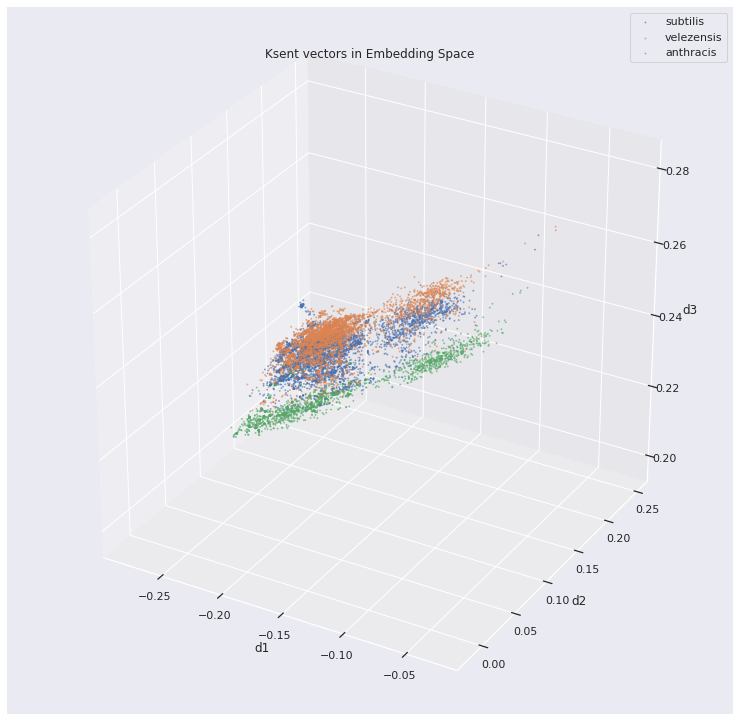

In [101]:
plot_3d(d, "Ksent vectors in Embedding Space")

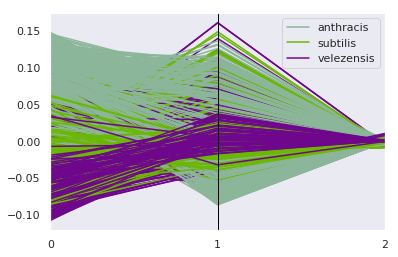

In [107]:
_ = pd.plotting.parallel_coordinates(d.reset_index(),"spicies")

#### TSNE Reduction

In [108]:
perplexity = 50
%time tsne = TSNE(n_components=3, perplexity=perplexity).fit_transform(d.values)
d = pd.DataFrame(tsne, index = vectors.index)

CPU times: user 5min 49s, sys: 72.2 ms, total: 5min 49s
Wall time: 5min 49s


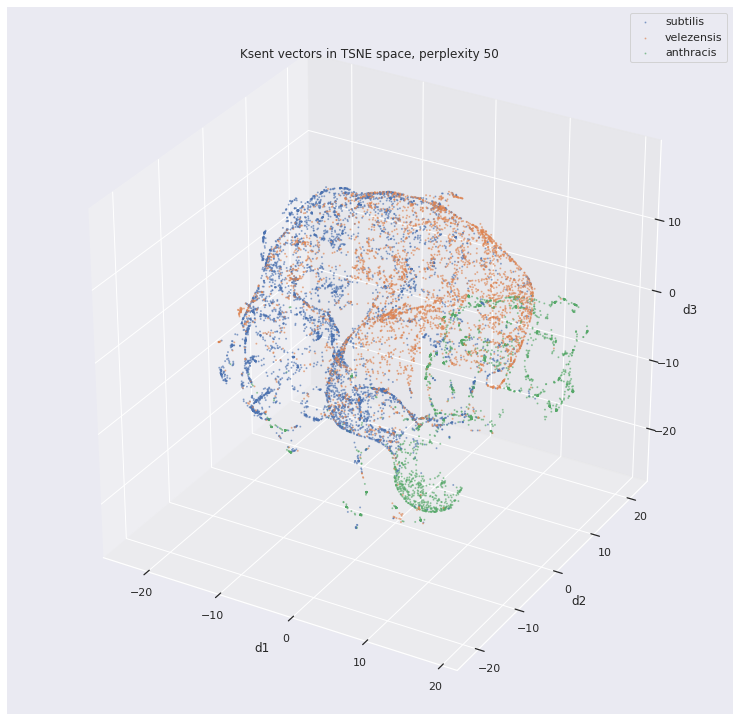

In [109]:
plot_3d(d,f"Ksent vectors in TSNE space, perplexity {perplexity}" )

#### PCA Reduction

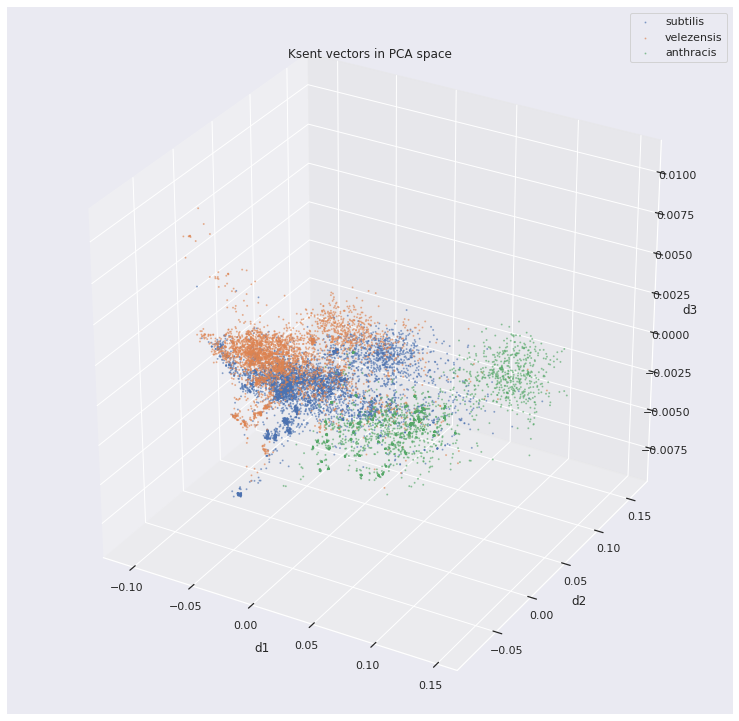

In [106]:
d = PCA(n_components=3).fit_transform(d.values)
d = pd.DataFrame(d,index = vectors.index)

plot_3d(d, "Ksent vectors in PCA space")
